In [23]:
import pandas as pd
import browser_cookie3
from datetime import datetime, date
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from Bond import Bond, ZeroCouponBond
from vanguard.vg_fund import vg_multi_vol_analytics

%load_ext autoreload
%autoreload 2

            1 Mo  2 Mo  3 Mo  4 Mo  6 Mo  1 Yr  2 Yr  3 Yr  5 Yr  7 Yr  10 Yr  \
Date                                                                            
2023-10-31  5.56  5.57  5.59  5.61  5.54  5.44  5.07  4.90  4.82  4.89   4.88   
2023-10-30  5.56  5.57  5.60  5.61  5.53  5.41  5.03  4.87  4.80  4.88   4.88   
2023-10-27  5.57  5.57  5.59  5.60  5.55  5.39  4.99  4.84  4.76  4.83   4.84   
2023-10-26  5.57  5.57  5.59  5.60  5.55  5.39  5.02  4.89  4.79  4.86   4.86   
2023-10-25  5.56  5.57  5.59  5.61  5.57  5.43  5.08  4.98  4.89  4.98   4.95   

            20 Yr  30 Yr  
Date                      
2023-10-31   5.21   5.04  
2023-10-30   5.21   5.04  
2023-10-27   5.19   5.03  
2023-10-26   5.19   5.01  
2023-10-25   5.27   5.09  
           navPrice
Date               
2023-10-31   $63.17
2023-10-30   $63.71
2023-10-27   $64.05
2023-10-26   $64.49
2023-10-25   $63.12
r2 0.9725865172461431


C:\Users\chris\AppData\Local\Temp\ipykernel_4176\725532872.py:13: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df["navPrice"] = df["navPrice"].str.replace("$", "")


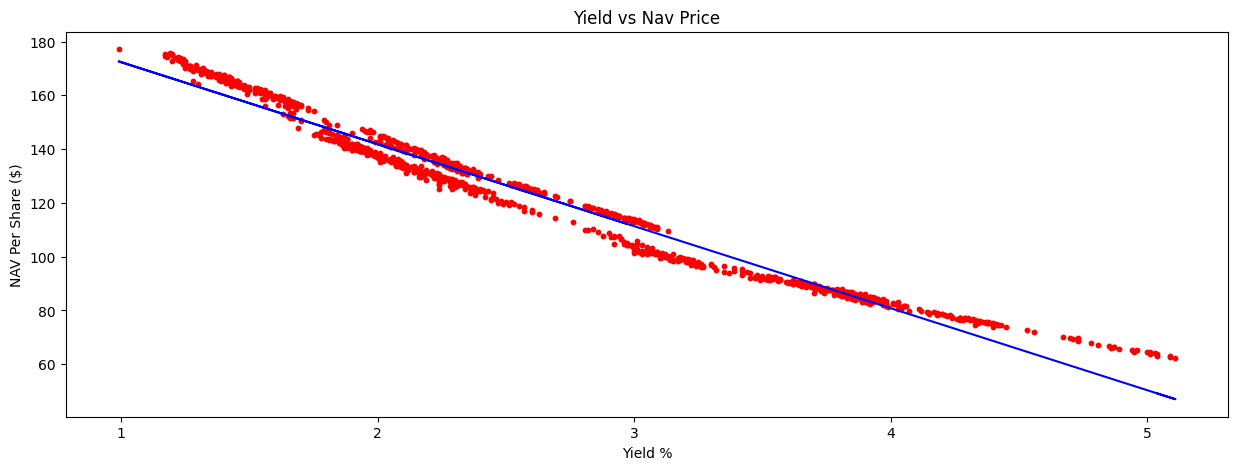

In [19]:
df_treasuries = pd.read_excel(r'C:\Users\chris\trade\curr_pos\utils\treasuries\2023_2022_2021_2020_2019_daily_treasury_rates.xlsx', parse_dates=['Date'], index_col=0)
df_nav = pd.read_excel(r'C:\Users\chris\trade\curr_pos\vanguard\vg_nav_data\EDV_nav_prices.xlsx', parse_dates=['date'], index_col=0)
df_nav = df_nav.query("date >= '2019-01-01'")
df_nav.index = df_nav.index.rename('Date')
df_nav = df_nav.iloc[::-1]

print(df_treasuries.head())
print(df_nav.head())

df = df_nav.merge(df_treasuries, left_index=True, right_index=True, how='inner')
df = df.sort_index()

df["navPrice"] = df["navPrice"].str.replace("$", "")
df["navPrice"] = df["navPrice"].str.replace(",", "")
df["navPrice"] = df["navPrice"].astype("float")

x = df[["30 Yr"]]
y = df[["navPrice"]]

regressor = LinearRegression()
model = regressor.fit(x, y)
y_pred = regressor.predict(x)

r2 = model.score(x, y)
print('r2', r2)

plt.figure(figsize=(15, 5))
plt.scatter(x, y, color = 'red', s=10)
plt.plot(x, regressor.predict(x), color = 'blue')

plt.title('Yield vs Nav Price')
plt.xlabel('Yield %')
plt.ylabel('NAV Per Share ($)')

plt.show()

In [6]:
def vg_risk_calcs(df: pd.DataFrame, is_zero_coupon = False) -> pd.DataFrame:
    df["couponRate"] = df["couponRate"].apply(lambda x: x / 100)
    df["maturityDate"] = df["maturityDate"].apply(Bond.calc_time_to_maturity)
    
    if is_zero_coupon:
        df["YTM"] = df.apply(
            lambda row: ZeroCouponBond.calc_YTM(
                row["faceAmount"], row["marketValue"], row["maturityDate"]
            ),
            axis=1,
        )
        df["macaulayDuration"] = df.apply(
            lambda row: ZeroCouponBond.calc_macaulay_duration(row["maturityDate"]),
            axis=1,
        )
        df["modifiedDuration"] = df.apply(
            lambda row: ZeroCouponBond.calc_modified_duration(
                row["maturityDate"], row["YTM"]
            ),
            axis=1,
        )
        df["convexity"] = df.apply(
            lambda row: ZeroCouponBond.calc_convexity(
                row["maturityDate"], row["YTM"]
            ),
            axis=1,
        )
        df["marketPrice"] = df.apply(
            lambda row: ZeroCouponBond.calc_market_price(
                row["faceAmount"], row["YTM"], row["maturityDate"]
            ),
            axis=1,
        )
    else:
        df["YTM"] = df.apply(
            lambda row: Bond.calc_YTM(
                row["faceAmount"],
                row["couponRate"],
                row["marketValue"],
                row["maturityDate"],
                n=1,
            ),
            axis=1,
        )
        df["currentYield"] = df.apply(
            lambda row: Bond.calc_current_yield(
                row["faceAmount"], row["couponRate"], row["marketValue"]
            ),
            axis=1,
        )
        df["macaulayDuration"] = df.apply(
            lambda row: Bond.calc_macaulay_duration(
                row["faceAmount"],
                row["couponRate"],
                row["marketValue"],
                row["maturityDate"],
                row["YTM"],
                n=1,
            ),
            axis=1,
        )
        df["modifiedDuration"] = df.apply(
            lambda row: Bond.calc_modifed_duration(
                row["faceAmount"],
                row["couponRate"],
                row["marketValue"],
                row["maturityDate"],
                n=1,
            ),
            axis=1,
        )
        df["convexity"] = df.apply(
            lambda row: Bond.calc_convexity(
                row["faceAmount"],
                row["couponRate"],
                row["marketValue"],
                row["maturityDate"],
                n=1,
            ),
            axis=1,
        )
        
    return df

In [38]:
import json
import numpy as np

class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NpEncoder, self).default(obj)

In [44]:
ticker = "VGSH"
path = rf"C:\Users\chris\trade\curr_pos\vanguard\vg_funds_holdings_clean_data\09-30-2023_{ticker}_holdings_data_clean.xlsx"
df = pd.read_excel(path)
df = vg_risk_calcs(df)

"""
- weighted avg mauturity

- weighted avg coupon
- weighted avg ytm
- weighted avg current yield

- weighted avg mac duration
- weighted avg mod duration
- weighted avg convexvity

- total face amount
- total market value
- total holdings

- turnover rate

"""


def vg_holdings_summary_sheet(df):
    # from_vg = vg_multi_vol_analytics(ticker)

    temp_df = pd.DataFrame()
    temp_df["Weighted Maturity"] = df.apply(
        lambda row: row["percentWeight"] * row["maturityDate"],
        axis=1,
    )
    temp_df["Weighted Coupon"] = df.apply(
        lambda row: row["percentWeight"] * row["couponRate"],
        axis=1,
    )
    temp_df["Weighted YTM"] = df.apply(
        lambda row: row["percentWeight"] * row["YTM"],
        axis=1,
    )
    temp_df["Weighted Current Yield"] = df.apply(
        lambda row: row["percentWeight"] * row["currentYield"],
        axis=1,
    )
    temp_df["Weighted Mac Duration"] = df.apply(
        lambda row: row["percentWeight"] * row["macaulayDuration"],
        axis=1,
    )
    temp_df["Weighted Mod Duration"] = df.apply(
        lambda row: row["percentWeight"] * row["modifiedDuration"],
        axis=1,
    )
    temp_df["Weighted Convexity"] = df.apply(
        lambda row: row["percentWeight"] * row["convexity"],
        axis=1,
    )
    
    summary_dict = {}  
    summary_dict["Weighted Avg Maturity"] = temp_df["Weighted Maturity"].sum() / 100
    summary_dict["Weighted Avg Coupon"] = temp_df["Weighted Coupon"].sum() / 100
    summary_dict["Weighted Avg YTM"] = temp_df["Weighted YTM"].sum() / 100
    summary_dict["Weighted Avg Current Yield"] = temp_df["Weighted Current Yield"].sum() / 100
    summary_dict["Weighted Avg Mac Duration"] = temp_df["Weighted Mac Duration"].sum() / 100
    summary_dict["Weighted Avg Mod Duration"] = temp_df["Weighted Mod Duration"].sum() / 100
    summary_dict["Weighted Avg Convexity"] = temp_df["Weighted Convexity"].sum() / 100
    summary_dict["Face Amount"] = df["faceAmount"].sum()
    summary_dict["Total Market Value"] = df["marketValue"].sum()
    summary_dict["Holdings Count"] = df.shape[0]

    return summary_dict

# dict = vg_holdings_summary_sheet(df)

# print(json.dumps(dict, cls=NpEncoder, indent=4))

# vg_multi_vol_analytics('VGSH')

data = {
    "VGSH": {
        "Weighted Avg Maturity": 1.861791506849315,
        "Weighted Avg Coupon": 0.023242749999999996,
        "Weighted Avg YTM": 0.05311700567531705,
        "Weighted Avg Current Yield": 0.02401800811886967,
        "Weighted Avg Mac Duration": 1.817929075302791,
        "Weighted Avg Mod Duration": 1.7273940621922146,
        "Weighted Avg Convexity": 4.680327279673221,
        "Face Amount": 27905498000,
        "Total Market Value": 26461957712,
        "Holdings Count": 97
    }
}

# Convert the inner dictionary to a DataFrame with columns
df_corrected = pd.DataFrame.from_dict(data, orient='index')

      Weighted Avg Maturity  Weighted Avg Coupon  Weighted Avg YTM  \
VGSH               1.861792             0.023243          0.053117   

      Weighted Avg Current Yield  Weighted Avg Mac Duration  \
VGSH                    0.024018                   1.817929   

      Weighted Avg Mod Duration  Weighted Avg Convexity  Face Amount  \
VGSH                   1.727394                4.680327  27905498000   

      Total Market Value  Holdings Count  
VGSH         26461957712              97  


In [7]:
wb = pd.read_excel(
    r"C:\Users\chris\ETF_Fund_Flows\data\blackrock\TLT_blk_fund_data.xlsx",
    sheet_name=["Holdings"],
    skiprows=7,
)

df = wb["Holdings"]

format = "%b %d, %Y"
df["TTM"] = df["Maturity"].apply(lambda x: Bond.calc_time_to_maturity_blk(x))

df["Convexity"] = df.apply(
    lambda row: Bond.calc_convexity(
        row["Par Value"],
        row["Coupon (%)"] / 100,
        row["Market Value"],
        row["TTM"],
        n=1,
    ),
    axis=1,
)

df.to_excel('tlt_with_convexity.xlsx', index=False)
df.head()

Invalid date format: time data '--' does not match format '%b %d, %Y'
Invalid date format: time data '--' does not match format '%b %d, %Y'
Failed to converge. Error: Failed to converge after 50 iterations, value is nan.
unsupported operand type(s) for /: 'str' and 'int'
Failed to converge. Error: float division by zero
unsupported operand type(s) for /: 'str' and 'int'


,Name,Sector,Asset Class,Market Value,Weight (%),Notional Value,Par Value,Price,Location,Exchange,...,Mod. Duration,Yield to Call (%),Yield to Worst (%),Real Duration,Real YTM (%),Market Currency,Accrual Date,Effective Date,TTM,Convexity
0,TREASURY BOND,Treasuries,Fixed Income,3.506953e+09,8.74324,3.506953e+09,6535490300,53.29,United States,--,...,18.21,--,5.04,18.21,5.04,USD,"Feb 15, 2021","Feb 16, 2021",27.306849,230.063456
1,TREASURY BOND,Treasuries,Fixed Income,2.899267e+09,7.22821,2.899267e+09,5245591000,54.88,United States,--,...,18.13,--,5.03,18.13,5.03,USD,"Aug 15, 2021","Aug 16, 2021",27.802740,236.546193
2,TREASURY BOND,Treasuries,Fixed Income,2.585548e+09,6.44607,2.585548e+09,5123678100,49.74,United States,--,...,18.54,--,5.05,18.54,5.05,USD,"Nov 15, 2020","Nov 16, 2020",27.054795,224.272988
3,TREASURY BOND,Treasuries,Fixed Income,2.215712e+09,5.52403,2.215712e+09,4117768400,52.97,United States,--,...,18.33,--,5.02,18.33,5.02,USD,"Nov 15, 2021","Nov 15, 2021",28.054795,241.392297
4,TREASURY BOND,Treasuries,Fixed Income,1.935879e+09,4.82637,1.935879e+09,2747542700,69.87,United States,--,...,15.32,--,5.20,15.32,5.20,USD,"Feb 15, 2018","Feb 15, 2018",24.304110,221.822866


In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [189]:
def create_volatility_surface(df, elev=10, azim=60, plot_points=False, original=False):
    df["expiration"] = pd.to_datetime(df["expirationDate"], unit="s")

    calls = df[["strike", "expiration", "impliedVolatility_call"]]
    puts = df[["strike", "expiration", "impliedVolatility_put"]]

    vol_data = pd.concat(
        [
            calls.rename(columns={"impliedVolatility_call": "impliedVolatility"}),
            puts.rename(columns={"impliedVolatility_put": "impliedVolatility"}),
        ]
    )

    vol_data["DTE"] = (vol_data["expiration"] - pd.Timestamp.today()).dt.days
    vol_data = vol_data[vol_data["DTE"] >= 0]
    vol_data_grouped = (
        vol_data.groupby(["strike", "DTE"])
        .agg({"impliedVolatility": "mean"})
        .reset_index()
    )
    vol_surface = vol_data_grouped.pivot(
        "strike", "DTE", "impliedVolatility"
    ).sort_index(ascending=False)
    vol_surface_filled = (
        vol_surface.interpolate(method="linear", axis=0)
        .fillna(method="bfill")
        .fillna(method="ffill")
    )

    if original:
        X = vol_surface_filled.columns.values
        Y = vol_surface_filled.index.values
        X, Y = np.meshgrid(X, Y)
        Z = vol_surface_filled.values        
    else:
        Y = vol_surface_filled.columns.values  
        X = vol_surface_filled.index.values   
        X, Y = np.meshgrid(X, Y)  
        Z = vol_surface_filled.values.T

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(X, Y, Z, cmap="viridis", edgecolor="none", alpha=0.8)

    if plot_points:
        for _, row in vol_data.iterrows():
            ax.scatter(
                row["DTE"], row["strike"], row["impliedVolatility"], color="red", s=10
            )

    ax.view_init(elev=elev, azim=azim)

    if original:
        ax.invert_xaxis() 
        ax.set_xlabel("Days to Expiration")
        ax.set_ylabel("Strike Price")
        ax.set_zlabel("Implied Volatility")
        ax.set_title("Volatility Surface with Strike Price")
    else:
        ax.invert_yaxis()
        ax.invert_xaxis()
        ax.set_ylabel("Days to Expiration")
        ax.set_xlabel("Strike Price")
        ax.set_zlabel("Implied Volatility")
        ax.set_title("Volatility Surface with Strike Price") 

    plt.show()


In [166]:
# not working

# def create_volatility_surface_with_moneyness(df, current_price, elev=10, azim=60, plot_points=False):
#     df["expiration"] = pd.to_datetime(df["expirationDate"], unit="s")
#     df["moneyness"] = df["strike"] / current_price

#     calls = df[["moneyness", "expiration", "impliedVolatility_call"]]
#     puts = df[["moneyness", "expiration", "impliedVolatility_put"]]

#     vol_data = pd.concat(
#         [
#             calls.rename(columns={"impliedVolatility_call": "impliedVolatility"}),
#             puts.rename(columns={"impliedVolatility_put": "impliedVolatility"}),
#         ]
#     )
#     vol_data["DTE"] = (vol_data["expiration"] - pd.Timestamp.today()).dt.days
#     vol_data = vol_data[vol_data["DTE"] >= 0]
#     vol_data_grouped = (
#         vol_data.groupby(["moneyness", "DTE"])
#         .agg({"impliedVolatility": "mean"})
#         .reset_index()
#     )
#     vol_surface = vol_data_grouped.pivot("moneyness", "DTE", "impliedVolatility")
#     vol_surface_filled = (
#         vol_surface.interpolate(method="linear", axis=0)
#         .fillna(method="bfill")
#         .fillna(method="ffill")
#     )

#     Y = list(vol_surface_filled.index.values)
#     X = list(vol_surface_filled.columns.values)
#     X.reverse()
#     X.reverse
#     print(X)
#     X, Y = np.meshgrid(X, Y)
#     Z = vol_surface_filled.values

#     fig = plt.figure(figsize=(12, 8))
#     ax = fig.add_subplot(111, projection="3d")
#     ax.plot_surface(Y, X, Z, cmap="viridis", edgecolor="none", alpha=0.8)

#     if plot_points:
#         for _, row in vol_data.iterrows():
#             ax.scatter(
#                 row["moneyness"], row["DTE"], row["impliedVolatility"], color="red", s=10
#             )

#     # Adjust the view angle
#     ax.view_init(elev=elev, azim=azim)

#     ax.set_xlabel("Moneyness")
#     ax.set_ylabel("Days to Expiration")
#     ax.set_zlabel("Implied Volatility")
#     ax.set_title("Volatility Surface with Moneyness")

#     plt.show()

C:\Users\chris\AppData\Local\Temp\ipykernel_9096\1865919865.py:21: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  vol_surface = vol_data_grouped.pivot(


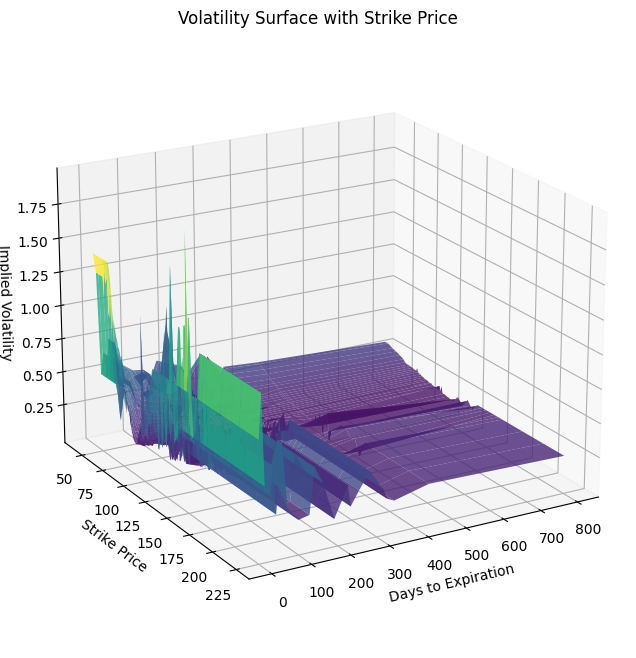

C:\Users\chris\AppData\Local\Temp\ipykernel_9096\1865919865.py:21: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  vol_surface = vol_data_grouped.pivot(


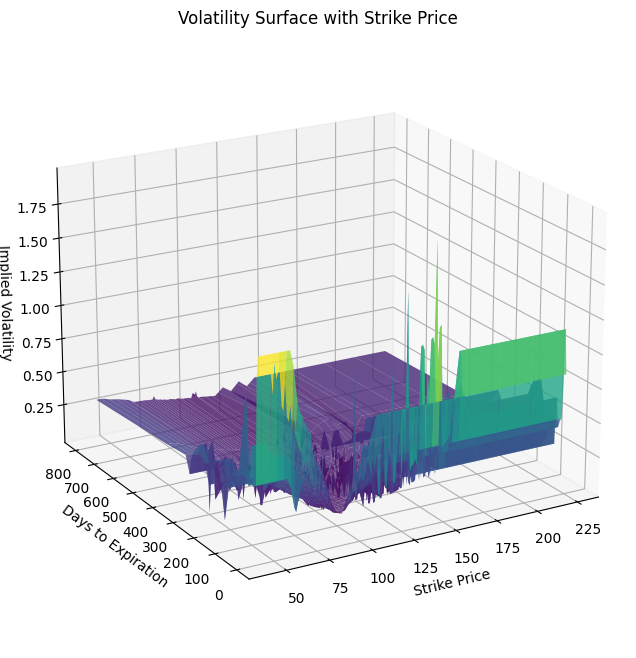

In [191]:
df_tlt = pd.read_excel(
    r"C:\Users\chris\trade\curr_pos\utils\yahoofinance\option_chains\TLT_option_chain.xlsx",
    sheet_name="all",
)

create_volatility_surface(df_tlt, elev=20, azim=60, original=True)
create_volatility_surface(df_tlt, elev=20, azim=60, original=False)

C:\Users\chris\AppData\Local\Temp\ipykernel_9096\4125540593.py:26: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  vol_surface = vol_data_grouped.pivot(


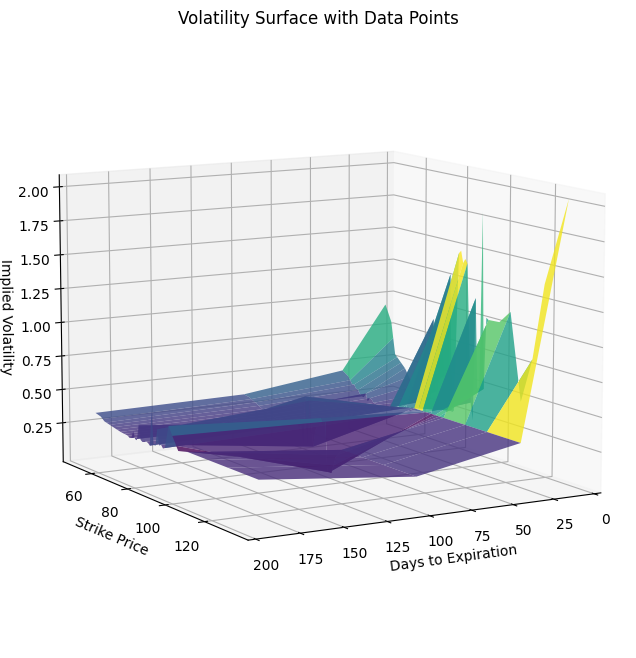

In [84]:
df_edv = pd.read_excel(
    r"C:\Users\chris\trade\curr_pos\utils\yahoofinance\option_chains\EDV_option_chain.xlsx",
    sheet_name="all",
)
create_volatility_surface(df_edv)